In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchvision
import torchvision.transforms as T
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.controller.recorder import TrainRecorder
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.random import generate_normal
from torchlake.image_generation.controllers.trainer_gan import GANTrainer
from torchlake.image_generation.models.dcgan import (DCGANDiscriminator,
                                                     DCGANGenerator)
from torchlake.image_generation.models.gan import GANDiscriminatorLoss, GANGeneratorLoss
from tqdm import tqdm

# Setting

In [127]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

In [128]:
artifact_path = Path('../../artifacts/dcgan')
artifact_path.mkdir(exist_ok=True)

data_path = Path('../../data/cifar10')

In [129]:
DEVICE = torch.device('cuda:0')

# Data

In [130]:
preprocess = T.Compose(
    [
        T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        T.ToTensor(),
        lambda x: 2 * x - 1,
    ]
)

In [131]:
train_data = torchvision.datasets.CIFAR10(
    root=data_path.as_posix(),
    train=True,
    transform=preprocess,
)

test_data = torchvision.datasets.CIFAR10(
    root=data_path.as_posix(),
    train=True,
    transform=preprocess,
)

In [132]:
for img, _ in train_data:
    print(img.shape)
    break

torch.Size([3, 32, 32])


In [133]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

test_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
)

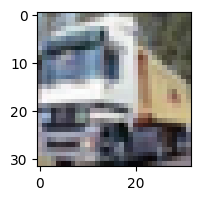

In [134]:
# 資料集繪圖
plt.figure(figsize=(2, 2))
plt.imshow(
    img_tensor_to_np((train_data[1][0] + 1) / 2), 
    # cmap='gray',
)

# model

In [135]:
LATENT_DIM = 128
HIDDEN_DIM = 1024
NUM_BLOCK = 4

In [136]:
# 2 x 16 = 32
generator = DCGANGenerator(LATENT_DIM, 3, HIDDEN_DIM, num_block=NUM_BLOCK, init_shape=(2, 2)).to(DEVICE)
# 32 / 32 = 1
discriminator = DCGANDiscriminator(3, HIDDEN_DIM // (2**NUM_BLOCK), image_shape=(IMAGE_SIZE, IMAGE_SIZE), num_block=NUM_BLOCK).to(DEVICE)

In [137]:
torchinfo.summary(generator)

Layer (type:depth-idx)                   Param #
DCGANGenerator                           --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       528,384
│    └─Unflatten: 2-2                    --
│    └─BatchNorm2d: 2-3                  2,048
├─Sequential: 1-2                        --
│    └─ConvBNReLU: 2-4                   --
│    │    └─ConvTranspose2d: 3-1         8,388,608
│    │    └─BatchNorm2d: 3-2             1,024
│    │    └─ReLU: 3-3                    --
│    └─ConvBNReLU: 2-5                   --
│    │    └─ConvTranspose2d: 3-4         2,097,152
│    │    └─BatchNorm2d: 3-5             512
│    │    └─ReLU: 3-6                    --
│    └─ConvBNReLU: 2-6                   --
│    │    └─ConvTranspose2d: 3-7         524,288
│    │    └─BatchNorm2d: 3-8             256
│    │    └─ReLU: 3-9                    --
│    └─ConvBNReLU: 2-7                   --
│    │    └─ConvTranspose2d: 3-10        131,072
│    │    └─BatchNorm2d: 3-11     

In [138]:
generator

DCGANGenerator(
  (foot): Sequential(
    (0): Linear(in_features=128, out_features=4096, bias=True)
    (1): Unflatten(dim=-1, unflattened_size=(1024, 2, 2))
    (2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (blocks): Sequential(
    (0): ConvBNReLU(
      (conv): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (1): ConvBNReLU(
      (conv): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (2): ConvBNReLU(
      (conv): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [139]:
torchinfo.summary(discriminator)

Layer (type:depth-idx)                   Param #
DCGANDiscriminator                       --
├─Sequential: 1-1                        --
│    └─Conv2dNormActivation: 2-1         --
│    │    └─Conv2d: 3-1                  1,792
│    │    └─LeakyReLU: 3-2               --
├─Sequential: 1-2                        --
│    └─Conv2dNormActivation: 2-2         --
│    │    └─Conv2d: 3-3                  73,728
│    │    └─BatchNorm2d: 3-4             256
│    │    └─LeakyReLU: 3-5               --
│    └─Conv2dNormActivation: 2-3         --
│    │    └─Conv2d: 3-6                  294,912
│    │    └─BatchNorm2d: 3-7             512
│    │    └─LeakyReLU: 3-8               --
│    └─Conv2dNormActivation: 2-4         --
│    │    └─Conv2d: 3-9                  1,179,648
│    │    └─BatchNorm2d: 3-10            1,024
│    │    └─LeakyReLU: 3-11              --
│    └─Conv2dNormActivation: 2-5         --
│    │    └─Conv2d: 3-12                 4,718,592
│    │    └─BatchNorm2d: 3-13           

In [140]:
discriminator

DCGANDiscriminator(
  (foot): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
  (blocks): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Conv2dNormActivation(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)


# train

In [141]:
EPOCH = 30

In [142]:
trainer = GANTrainer(EPOCH, DEVICE)
# trainer.set_discriminator_cycle(2)

In [143]:
recorder = TrainRecorder(total_epoch=EPOCH, num_loss=2, loss_names=["discriminator", "generator"])
recorder.increment_data_size(len(train_data))

In [144]:
LR = 5e-5
BETA = (0.5, 0.999)

In [ ]:
criterion_g = GANGeneratorLoss()
criterion_d = GANDiscriminatorLoss()
optim_g = torch.optim.Adam(generator.parameters(), lr=LR , betas=BETA)
optim_d = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=BETA)

In [ ]:
from typing import Any, Generator

def noise_generator(batch: tuple[Any]) -> Generator[torch.Tensor, None, None]:
    batch_size = len(batch[0])
    
    while True:
        yield generate_normal(batch_size, LATENT_DIM).to(DEVICE)

In [ ]:
training_losses = trainer.run(
    train_loader,
    noise_generator,
    generator,
    discriminator,
    optim_g,
    optim_d,
    criterion_g,
    criterion_d,
    recorder=recorder,
)

Enable AMP: False


100%|██████████| 781/781 [00:31<00:00, 24.77it/s]


------------------------------------
Epoch 1
------------------------------------
discriminator: 8.4203e-03 (0.00%)
generator: 1.5746e-02 (0.00%)


100%|██████████| 781/781 [00:30<00:00, 25.50it/s]


------------------------------------
Epoch 2
------------------------------------
discriminator: 1.8644e-02 (121.00%)
generator: 2.8149e-02 (79.00%)


100%|██████████| 781/781 [00:29<00:00, 26.43it/s]


------------------------------------
Epoch 3
------------------------------------
discriminator: 2.9006e-02 (56.00%)
generator: 4.0222e-02 (43.00%)


100%|██████████| 781/781 [00:29<00:00, 26.48it/s]


------------------------------------
Epoch 4
------------------------------------
discriminator: 3.9461e-02 (36.00%)
generator: 5.2066e-02 (29.00%)


100%|██████████| 781/781 [00:30<00:00, 26.03it/s]


------------------------------------
Epoch 5
------------------------------------
discriminator: 4.9899e-02 (26.00%)
generator: 6.3943e-02 (23.00%)


100%|██████████| 781/781 [00:29<00:00, 26.07it/s]


------------------------------------
Epoch 6
------------------------------------
discriminator: 6.0273e-02 (21.00%)
generator: 7.5967e-02 (19.00%)


100%|██████████| 781/781 [00:30<00:00, 25.51it/s]


------------------------------------
Epoch 7
------------------------------------
discriminator: 7.0637e-02 (17.00%)
generator: 8.7936e-02 (16.00%)


100%|██████████| 781/781 [00:29<00:00, 26.48it/s]


------------------------------------
Epoch 8
------------------------------------
discriminator: 8.0959e-02 (15.00%)
generator: 9.9990e-02 (14.00%)


100%|██████████| 781/781 [00:28<00:00, 27.37it/s]


------------------------------------
Epoch 9
------------------------------------
discriminator: 9.1274e-02 (13.00%)
generator: 1.1195e-01 (12.00%)


100%|██████████| 781/781 [00:28<00:00, 27.35it/s]


------------------------------------
Epoch 10
------------------------------------
discriminator: 1.0153e-01 (11.00%)
generator: 1.2408e-01 (11.00%)


100%|██████████| 781/781 [00:28<00:00, 27.37it/s]


------------------------------------
Epoch 11
------------------------------------
discriminator: 1.1174e-01 (10.00%)
generator: 1.3629e-01 (10.00%)


100%|██████████| 781/781 [00:28<00:00, 27.45it/s]


------------------------------------
Epoch 12
------------------------------------
discriminator: 1.2188e-01 (9.00%)
generator: 1.4865e-01 (9.00%)


100%|██████████| 781/781 [00:28<00:00, 27.44it/s]


------------------------------------
Epoch 13
------------------------------------
discriminator: 1.3197e-01 (8.00%)
generator: 1.6111e-01 (8.00%)


100%|██████████| 781/781 [00:28<00:00, 27.49it/s]


------------------------------------
Epoch 14
------------------------------------
discriminator: 1.4197e-01 (8.00%)
generator: 1.7371e-01 (8.00%)


100%|██████████| 781/781 [00:28<00:00, 27.13it/s]


------------------------------------
Epoch 15
------------------------------------
discriminator: 1.5184e-01 (7.00%)
generator: 1.8658e-01 (7.00%)


100%|██████████| 781/781 [00:28<00:00, 27.26it/s]


------------------------------------
Epoch 16
------------------------------------
discriminator: 1.6155e-01 (6.00%)
generator: 1.9986e-01 (7.00%)


100%|██████████| 781/781 [00:29<00:00, 26.85it/s]


------------------------------------
Epoch 17
------------------------------------
discriminator: 1.7110e-01 (6.00%)
generator: 2.1344e-01 (7.00%)


100%|██████████| 781/781 [00:29<00:00, 26.28it/s]


------------------------------------
Epoch 18
------------------------------------
discriminator: 1.8058e-01 (6.00%)
generator: 2.2721e-01 (6.00%)


100%|██████████| 781/781 [00:29<00:00, 26.49it/s]


------------------------------------
Epoch 19
------------------------------------
discriminator: 1.8992e-01 (5.00%)
generator: 2.4117e-01 (6.00%)


100%|██████████| 781/781 [00:29<00:00, 26.41it/s]


------------------------------------
Epoch 20
------------------------------------
discriminator: 1.9912e-01 (5.00%)
generator: 2.5552e-01 (6.00%)


100%|██████████| 781/781 [00:29<00:00, 26.40it/s]


------------------------------------
Epoch 21
------------------------------------
discriminator: 2.0815e-01 (5.00%)
generator: 2.7028e-01 (6.00%)


100%|██████████| 781/781 [00:29<00:00, 26.63it/s]


------------------------------------
Epoch 22
------------------------------------
discriminator: 2.1705e-01 (4.00%)
generator: 2.8530e-01 (6.00%)


100%|██████████| 781/781 [00:29<00:00, 26.62it/s]


------------------------------------
Epoch 23
------------------------------------
discriminator: 2.2578e-01 (4.00%)
generator: 3.0076e-01 (5.00%)


100%|██████████| 781/781 [00:28<00:00, 27.06it/s]


------------------------------------
Epoch 24
------------------------------------
discriminator: 2.3437e-01 (4.00%)
generator: 3.1670e-01 (5.00%)


100%|██████████| 781/781 [00:28<00:00, 27.19it/s]


------------------------------------
Epoch 25
------------------------------------
discriminator: 2.4280e-01 (4.00%)
generator: 3.3312e-01 (5.00%)


100%|██████████| 781/781 [00:29<00:00, 26.83it/s]


------------------------------------
Epoch 26
------------------------------------
discriminator: 2.5106e-01 (3.00%)
generator: 3.4986e-01 (5.00%)


100%|██████████| 781/781 [00:29<00:00, 26.73it/s]


------------------------------------
Epoch 27
------------------------------------
discriminator: 2.5921e-01 (3.00%)
generator: 3.6705e-01 (5.00%)


100%|██████████| 781/781 [00:29<00:00, 26.78it/s]


------------------------------------
Epoch 28
------------------------------------
discriminator: 2.6722e-01 (3.00%)
generator: 3.8455e-01 (5.00%)


100%|██████████| 781/781 [00:29<00:00, 26.77it/s]


------------------------------------
Epoch 29
------------------------------------
discriminator: 2.7499e-01 (3.00%)
generator: 4.0253e-01 (5.00%)


100%|██████████| 781/781 [00:28<00:00, 27.11it/s]

------------------------------------
Epoch 30
------------------------------------
discriminator: 2.8264e-01 (3.00%)
generator: 4.2107e-01 (5.00%)


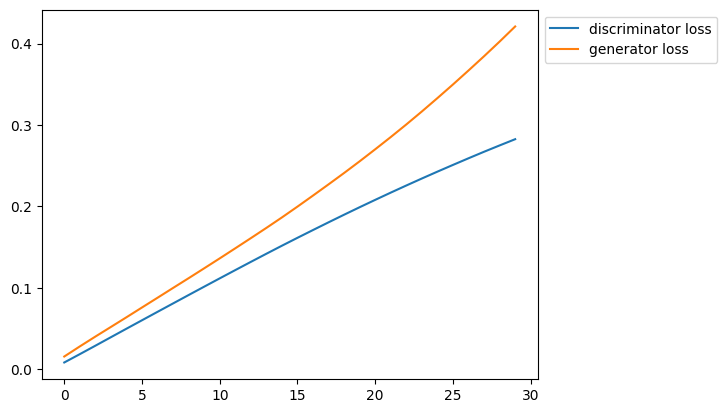

In [148]:
plt.plot(training_losses[0], label="discriminator loss")
plt.plot(training_losses[1], label="generator loss")
plt.legend(bbox_to_anchor=(1, 1))

# evaluation

In [149]:
TEST_BATCH_SIZE = 9

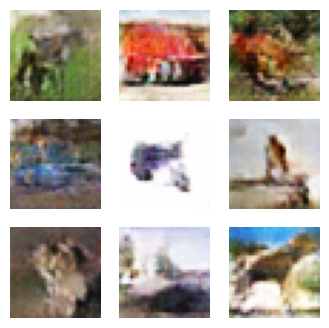

In [152]:
# 合成圖片
generator.eval()
with torch.no_grad():
    noise = generate_normal(TEST_BATCH_SIZE, LATENT_DIM).to(DEVICE)
    gen_img = (generator(noise) + 1) / 2
    
plot_grids(
    img_tensor_to_np(gen_img),
    num_row=3,
    num_col=3,
    figsize=(4,4),
    # cmap='gray',
)

In [153]:
# 區別是否為真實圖片
generator.eval()
discriminator.eval()
with torch.no_grad():
    hits = 0.0
    for img, _ in tqdm(test_loader):
        img = img.to(DEVICE)
        hits += discriminator(img).sigmoid().gt(0.5).sum().item()

    print(hits / len(train_data))

100%|██████████| 782/782 [00:18<00:00, 43.05it/s]

0.7897


In [154]:
# 區別是否為合成圖片
generator.eval()
discriminator.eval()
with torch.no_grad():
    hits = 0.0
    for img, _ in tqdm(test_loader):
        noise = torch.randn(BATCH_SIZE, LATENT_DIM).to(DEVICE)
        gen_img = generator(noise)
        hits += discriminator(gen_img).sigmoid().gt(0.5).sum().item()
    print(hits / len(train_data))

100%|██████████| 782/782 [00:23<00:00, 33.30it/s]

0.26754


In [158]:
from torchlake.common.controller.weight_manager import WeightManager

weight_manager = WeightManager(artifact_path.joinpath('dcgan.generator.pth').as_posix())

In [162]:
generator_path = weight_manager.get_filename()
generator_path

WindowsPath('../../artifacts/dcgan/dcgan.generator.pth')

In [161]:
weight_manager.save_weight(generator.state_dict(), generator_path)

Save weight to ..\..\artifacts\dcgan\dcgan.generator.pth, model size is 44.56MiB


In [163]:
weight_manager.load_weight(generator_path, generator)